# <hr style="clear: both" />

# Running Spark in YARN-client mode

This notebook demonstrates how to set up a SparkContext that uses SURFsara's Hadoop cluster: [YARN resourcemanager](http://head05.hathi.surfsara.nl:8088/cluster) (note you will need to be authenticated via kerberos on your machine to visit the resourcemanager link) for executors.

First initialize kerberos via a Jupyter terminal. 
In the terminal execute: <BR>
<i>kinit -k -t data/robertop.keytab robertop@CUA.SURFSARA.NL</i><BR>
Print your credentials:


In [1]:
! klist

Ticket cache: FILE:/tmp/krb5cc_1000
Default principal: robertop@CUA.SURFSARA.NL

Valid starting       Expires              Service principal
06/03/2016 07:11:25  06/04/2016 07:11:25  krbtgt/CUA.SURFSARA.NL@CUA.SURFSARA.NL
	renew until 06/03/2016 07:11:25


In [2]:
! hdfs dfs -ls 
execfile('../spark-scripts/bullet.py')

Found 5 items
drwx------   - robertop hdfs          0 2016-05-26 06:00 .Trash
drwxr-xr-x   - robertop hdfs          0 2016-06-03 08:26 .sparkStaging
drwx------   - robertop hdfs          0 2016-04-06 15:54 .staging
drwxr-xr-x   - robertop hdfs          0 2016-05-25 06:28 mattia
drwxr-xr-x   - robertop hdfs          0 2016-04-13 10:00 recsys2016Competition


Verify that we can browse HDFS:

Next initialize Spark. Note that the code below starts a job on the Hadoop cluster that will remain running while the notebook is active. Please close and halt the notebook when you are done. Starting the SparkContext can take a little longer. You can check the YARN resourcemanager to see the current status/usage of the cluster.

In [3]:
import os
os.environ['PYSPARK_PYTHON'] = '/usr/local/bin/python2.7'

HDFS_PATH = "hdfs://hathi-surfsara"

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sconf = SparkConf(False)

sconf.setAppName('collaborative')

# Master is now yarn-client. The YARN and hadoop config is read from the environment
sconf.setMaster("yarn-client")

# You can control many Spark settings via the SparkConf. This determines the amount of executors on the cluster:
sconf.set("spark.executor.instances", "200")
sconf.set("spark.executor.memory", "10g")

# UFW (firewall) is active on the VM. We explicitly opened these ports and Spark should not bind to random ports:
sconf.set("spark.driver.port", 51800)
sconf.set("spark.fileserver.port", 51801)
sconf.set("spark.broadcast.port", 51802)
sconf.set("spark.replClassServer.port", 51803)
sconf.set("spark.blockManager.port", 51804)
sconf.set("spark.authenticate", True)
sconf.set("spark.yarn.keytab", "/home/jovyan/work/data/robertop.keytab")
sconf.set("spark.yarn.access.namenodes", HDFS_PATH + ":8020")

try:
    sc = SparkContext(conf=sconf)
    sqlCtx = SQLContext(sc) 
    sendNotificationToMattia("Spark Context", "Ready!")
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err)) 
    print str(err)

# <hr style="clear: both" />

# Now you can run your code

Pick a clustering algorithm (name of the file that provides a classify(x,y [,threshold]) function)

# Reading the conf file

In [4]:
import json
import copy

BASE_PATH = HDFS_PATH + '/user/robertop/mattia'

conf = {}

conf['split'] = {}
conf['split']['reclistSize'] = 100
conf['split']['callParams'] = {}
conf['split']['excludeAlreadyListenedTest'] = True
conf['split']['name'] = 'test'
conf['split']['split'] = conf['split']['name']
conf['split']['minEventsPerUser'] = 5
conf['split']['inputData'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/SenzaRipetizioni_1'
#conf['split']['inputData'] = 's3n://contentwise-research-poli/30musicdataset/newFormat/relations/sessions.idomaar'
conf['split']['bucketName'] = BASE_PATH
conf['split']['percUsTr'] = 0.05
conf['split']['ts'] = int(0.75 * (1421745857 - 1390209860) + 1390209860) - 10000
conf['split']['minEventPerSession'] = 5
conf['split']['onlineTrainingLength'] = 5
conf['split']['GTlength'] = 1
conf['split']['minEventPerSessionTraining'] = 10
conf['split']['minEventPerSessionTest'] = 11
conf['split']['mode'] = 'session'
conf['split']['forceSplitCreation'] = False
conf['split']["prop"] = {'reclistSize': conf['split']['reclistSize']}
conf['split']['type'] = list
conf['split']['out'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/'
conf['split']['location'] = '30Mdataset/relations/sessions'

conf['evaluation'] = {}
conf['evaluation']['metric'] = {}
conf['evaluation']['metric']['type'] = 'recall'
conf['evaluation']['metric']['prop'] = {}
conf['evaluation']['metric']['prop']['N'] = [1,2,5,10,15,20,25,50,100]
conf['evaluation']['name'] = 'recall@N'

conf['general'] = {}
conf['general']['clientname'] = "clusterBase.split"
conf['general']['bucketName'] = BASE_PATH
conf['general']['tracksPath'] = '30Mdataset/entities/tracks.idomaar.gz'

conf['algo'] = {}
conf['algo']['name'] = 'ClusterBase'
conf['algo']['props'] = {}
# ***** EXAMPLE OF CONFIGURATION *****#
conf['algo']['props']["sessionJaccardShrinkage"] = 5
conf['algo']['props']["clusterSimilarityThreshold"] = 0.1
conf['algo']['props']["expDecayFactor"] = 0.7
# ****** END EXAMPLE ****************#



# Load Songs

In [27]:
import json
import string

def my_replace_punct(x):
    ret = ""
    for i in x:
        if i == '+':
            ret += ' '
        else:
            ret += i
    return ret

tracksRDD = sc.textFile(BASE_PATH + '/30Mdataset/entities/tracks.idomaar.gz')
tracksRDD = tracksRDD.repartition(200)
tracksRDD = tracksRDD.map(lambda x: x.split('\t')).map(lambda x: (x[1], json.loads(x[3])['name'].split('/') ) )
tracksRDD = tracksRDD.map(lambda x: (x[0], " ".join( (x[1][0], x[1][2]) ) )).distinct()
tracksRDD = tracksRDD.map(lambda x : (x[0], my_replace_punct(x[1])))

ZZ_TOP = 3893303
tracksRDD = tracksRDD.filter(lambda x: int(x[0]) < ZZ_TOP)

tracksIdsRDD = tracksRDD.map(lambda x: (int(x[0]), [x[0]]))

n_tracks = str(tracksRDD.count())
n_tracksID = str(tracksIdsRDD.count())
print "Tracks: " + n_tracks
print "IDs: " + n_tracksID

Tracks: 3893303
IDs: 3893303



# Load Sessions 


In [5]:
execfile('../spark-scripts/conventions.py')
execfile('../spark-scripts/splitCluster.py')
execfile('../spark-scripts/eval.py')
execfile('../spark-scripts/implicitPlaylistAlgoFunctions.py')
execfile('../spark-scripts/implicitPlaylistAlgoMain.py')

import json
execfile('../spark-scripts/utilsCluster.py')

train, test = loadDataset(conf)

train.take(3)

[u'{"id": "1880568", "linkedinfo": {"subjects": [{"type": "user", "id": 25088}], "objects": [{"playratio": 0.67, "playstart": 0, "action": "play", "playtime": 163, "type": "track", "id": 2895012}, {"playratio": 1.0, "playstart": 163, "action": "play", "playtime": 215, "type": "track", "id": 548739}, {"playratio": 0.99, "playstart": 378, "action": "play", "playtime": 190, "type": "track", "id": 1830769}, {"playratio": 1.0, "playstart": 568, "action": "play", "playtime": 261, "type": "track", "id": 2363674}, {"playratio": 0.87, "playstart": 829, "action": "play", "playtime": 188, "type": "track", "id": 325757}, {"playratio": 0.99, "playstart": 1017, "action": "play", "playtime": 212, "type": "track", "id": 2833842}, {"playratio": 1.0, "playstart": 1229, "action": "play", "playtime": 207, "type": "track", "id": 1885477}, {"playratio": 0.99, "playstart": 1436, "action": "play", "playtime": 182, "type": "track", "id": 2988740}, {"playratio": 1.04, "playstart": 1618, "action": "play", "playt

# Filter "skipped" songs and "problematic" song

In [6]:
trainRDD = train.map(json.loads)

MIN_LISTENING = 5

ZZ_TOP = 3893303

def filter_skipped(x):
    objects = x['linkedinfo']['objects']
    x['linkedinfo']['objects'] = []
    for i in objects:
        if i["action"] == "play" and i["id"] < ZZ_TOP:
            x['linkedinfo']['objects'].append(i)
    return x


trainFilteredRDD = trainRDD.map(filter_skipped) 
trainFilteredRDD.count()

487637

# Songs co-occurrences

In [7]:
def extract_co_occur(x):
    K = 3600 #one hour
    result = []
    for song in x['linkedinfo']['objects']:
        id1 = song['id']
        co_occ = []
        for song2 in x['linkedinfo']['objects']:
            id2 = song2['id']
            if id1 != id2:
                if abs(song['playstart'] - song2['playstart']) < K:
                    co_occ.append(id2)
        result.append( (id1, co_occ) )
    
    return result

co_occRDD = trainFilteredRDD.flatMap(extract_co_occur).reduceByKey(lambda x, y: list( set(x).union(set(y)) ) )
co_occRDD.take(1)

[(3211264,
  [2878411,
   2857367,
   3169077,
   2685196,
   330329,
   1544232,
   2402190,
   2402189,
   2402184,
   2402188,
   2402182,
   2402186,
   2402191,
   2402185,
   2402183,
   3211262,
   3211272,
   3211263])]

# Similar Sessions

# $Jaccard(A,B) > 0.25 $ 


In [8]:
# Map to (userID, session) and Group by Key
def session_to_songs(x):
    user = x['linkedinfo']['subjects'][0]['id']
    songs = [i['id'] for i in x['linkedinfo']['objects']]
    return (user, songs)

trainUserRDD = trainFilteredRDD.map( session_to_songs ).groupByKey()
print trainUserRDD.count()
trainUserRDD.take(1)

30505


[(25088, <pyspark.resultiterable.ResultIterable at 0x7f897ff41210>)]

In [9]:
SIM_THR = 0.25

def similar_sessions(x):
    sessions = list(x[1])
    l = len(sessions)
    couples = []
    
    for i in range(l):
        sess_1 = set(sessions[i])
        if not len(sess_1): continue;
            
        for j in range(i):
            sess_2 = set(sessions[j])
            if not len(sess_2): continue;
            num = float(len(sess_1 & sess_2))
            den = float(len(sess_1 | sess_2))
            sim_j = num / den
            
            if sim_j > SIM_THR:
                couples.append((sess_1, sess_2, sim_j))
    
    return couples


userSimSessRDD = trainUserRDD.flatMap(similar_sessions)
userSimSessRDD.count()

196235

# Exctract Couples of Candidate Songs from similar Sessions

In [10]:
def extract_couples(x):
    sim = x[2]
    result = []
    
    for i in x[0]:
        if i in x[1]:
            continue
            
        for j in x[1]:
            if i != j and not j in x[0]:
                candidate = ( str(i) + ' ' + str(j), sim) if i<j else ( str(j) + ' ' + str(i), sim)
                result.append(candidate)
    
    return result


couplesCandidateRDD = userSimSessRDD.flatMap(extract_couples)


# Load Couples

In [5]:
TEMP_FILE = BASE_PATH + '/tmp/collaborative/candidates_min_sim_2'
couplesCandidateRDD = sc.pickleFile(TEMP_FILE)
couplesCandidateRDD.take(3)

[('581350 3885509', 0.42857142857142855),
 ('581352 3885509', 0.42857142857142855),
 ('581354 3885509', 0.42857142857142855)]

# Reduce Method

In [11]:
def reduce_to_min(couplesCandidateRDD):
    couplesCandidateScoreRDD = couplesCandidateRDD.reduceByKey(lambda x,y: min(x,y))
    return couplesCandidateScoreRDD

def reduce_to_count(couplesCandidateRDD):
    couplesCandidateScoreRDD = couplesCandidateRDD.map(lambda x: (x[0], 1)).reduceByKey(lambda x,y: x + y)
    return couplesCandidateScoreRDD
    
def reduce_to_shrink(couplesCandidateRDD, S = 2):
    couplesCandidateScoreRDD = couplesCandidateRDD.groupByKey().mapValues(lambda x: float(sum(list(x))) / float(len(list(x)) + S) )
    return couplesCandidateScoreRDD

#Choose here the function
print couplesCandidateRDD.count()
couplesCandidateScoreRDD = reduce_to_shrink(couplesCandidateRDD)  
print couplesCandidateScoreRDD.count()
#----------------------#
scores = couplesCandidateScoreRDD.map(lambda x: x[1]).collect()


89783229
10042293


count    10042293.000000
mean            0.151610
std             0.071363
min             0.083423
25%             0.095238
50%             0.121795
75%             0.189574
max             0.789683
dtype: float64


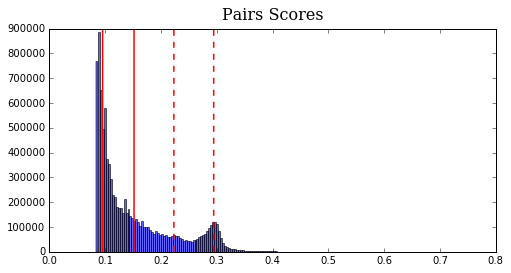

In [12]:

import pandas as pd
stats = pd.Series(scores).describe()
print stats

MEAN_SCORE = stats['mean']
STD_SCORE = stats['std']
Q1 = stats['25%']

from matplotlib import pyplot as plt
%matplotlib inline
font_title = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 16}  

plt.figure(1, figsize=(8,4))
plt.title("Pairs Scores", fontdict = font_title)
plt.hist(scores,200, alpha = 0.6, histtype='bar', log=False)
N = 900000
plt.plot( [MEAN_SCORE for i in range (N)], range(N), linewidth = 1.5, color = 'r')
plt.plot( [Q1 for i in range (N)], range(N), linewidth = 1.5, color = 'r')
plt.plot( [MEAN_SCORE + STD_SCORE for i in range (N)], range(N), 'r--', linewidth = 1.5)
plt.plot( [MEAN_SCORE + 2*STD_SCORE for i in range (N)], range(N), 'r--', linewidth = 1.5)
plt.show() 

In [13]:
couplesCandidateNewRDD = couplesCandidateScoreRDD.map(lambda x: ( int(x[0].split(' ')[0]), (int(x[0].split(' ')[1]), x[1]) ))
couplesCandidateNewRDD.count()

10042293

# Join with Co-Occurrences and Filter

In [14]:
def check_co_occur(x):
    co_occ = set(x[1][1])
    if x[1][0][0] in co_occ:
        return False
    return True

couplesJoinOccDD = couplesCandidateNewRDD.join(co_occRDD)
goodCandidatesRDD = couplesJoinOccDD.filter(check_co_occur).map(lambda x: ((x[0], x[1][0][0]), x[1][0][1] ))
goodCandidatesRDD.count()

8099962

# Keep top candidates

In [15]:
candidatesFlat = goodCandidatesRDD.flatMap(lambda x: [(i, (x[0], x[1])) for i in x[0]]).groupByKey()
candidatesFlat.count()

372532

In [16]:
def keep_top(x):
    top = max([i[1] for i in list(x[1])])
    result = set()
    for i in x[1]:
        if i[1] == top:
            result.add(i[0][0])
            result.add(i[0][1])
    return (x[0], sorted(list(result)))


def keep_higher(x):
    K = MEAN_SCORE
    result = set()
    for i in x[1]:
        if i[1] > K:
            result.add(i[0][0])
            result.add(i[0][1])
    return (x[0], sorted(list(result)))

def keep_all(x):
    result = set()
    for i in x[1]:
        result.add(i[0][0])
        result.add(i[0][1])
    return (x[0], sorted(list(result)))


topCandidates = candidatesFlat.map(keep_higher).filter(lambda x: len(x[1]))
topCandidates.take(3)

[(702464,
  [262027,
   262029,
   262030,
   262034,
   262037,
   262041,
   262043,
   262045,
   262049,
   262056,
   262061,
   262062,
   262067,
   262070,
   262072,
   262073,
   262074,
   262075,
   262076,
   262112,
   262113,
   262114,
   262116,
   262118,
   262119,
   262120,
   262123,
   262128,
   262131,
   262132,
   262135,
   262140,
   262141,
   262143,
   262149,
   262151,
   262152,
   262153,
   262157,
   262159,
   262161,
   262162,
   262163,
   262166,
   262167,
   262170,
   262171,
   262173,
   262175,
   262179,
   262180,
   262182,
   262189,
   262190,
   553561,
   553650,
   553651,
   553654,
   553658,
   553659,
   553660,
   553661,
   553662,
   553665,
   553667,
   553671,
   553672,
   553673,
   553678,
   553866,
   553867,
   553868,
   553869,
   698558,
   698559,
   698560,
   698561,
   698562,
   698563,
   698564,
   698565,
   698566,
   698567,
   698568,
   698569,
   698570,
   698571,
   698572,
   698573,
   698574,


In [17]:
uniqueClusters = topCandidates.map(lambda x: (' '.join([str(i) for i in x[1]]), x[0])).groupByKey()
uniqueClusters.count()

174844

In [18]:
clusters = topCandidates.map(lambda x: x[1]).collect()

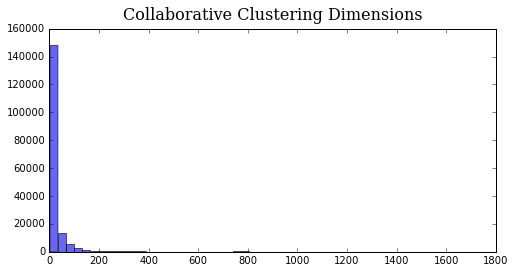

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
clusterDim = [len(i) for i in clusters]
font_title = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 16}  

plt.figure(1, figsize=(8,4))
plt.title("Collaborative Clustering Dimensions", fontdict = font_title)
plt.hist(clusterDim,50, alpha = 0.6, histtype='bar', log=False)
plt.show() 


In [20]:
import pandas as pd
pd.Series(clusterDim).describe()

count    175171.000000
mean         30.053257
std          95.059285
min           2.000000
25%           4.000000
50%           8.000000
75%          20.000000
max        1609.000000
dtype: float64

# Try to keep just the few cluster in accordance each other

In [21]:
topCandidatesGroup = topCandidates.map(lambda x: (' '.join(str(i) for i in sorted(x[1])), x[0])).groupByKey()
print topCandidates.count()
print topCandidatesGroup.count()

175171
174844


In [22]:
topCandidatesUnique = topCandidatesGroup.filter(lambda x: len(list(x[1])) == len(x[0].split(' ')))
topCandidatesUnique.mapValues(list).take(100)

[('1456387 1456572', [1456387, 1456572]),
 ('1106173 1106193', [1106173, 1106193]),
 ('3874822 3890014', [3890014, 3874822]),
 ('2802002 2802007', [2802007, 2802002]),
 ('1384214 1384258', [1384258, 1384214]),
 ('518936 1190059', [1190059, 518936]),
 ('253936 3833819', [253936, 3833819]),
 ('101898 101913', [101898, 101913]),
 ('280378 912970', [280378, 912970]),
 ('1269628 3270904', [3270904, 1269628]),
 ('545042 545079', [545079, 545042]),
 ('40803 2459750', [2459750, 40803]),
 ('88985 3027021', [3027021, 88985]),
 ('1237041 1237044', [1237041, 1237044]),
 ('1605134 2054549', [1605134, 2054549]),
 ('22427 3766447', [22427, 3766447]),
 ('1943729 2877342', [2877342, 1943729]),
 ('1060902 2037669', [1060902, 2037669]),
 ('2393374 2393414', [2393374, 2393414]),
 ('836315 1435469', [836315, 1435469]),
 ('371617 3462783', [371617, 3462783]),
 ('461176 1128853', [1128853, 461176]),
 ('217317 3154418', [3154418, 217317]),
 ('2386321 2386781', [2386321, 2386781]),
 ('58318 3074006', [58318, 3

In [23]:
topCandidatesUnique.map(lambda x: len(x[1])).stats()

(count: 307, mean: 2.00651465798, stdev: 0.0804500914347, max: 3.0, min: 2.0)

# Finalize

In [24]:
songToCluster = topCandidatesUnique.flatMap(lambda x: [(i, x[0]) for i in x[1]])
songToCluster.take(1)

[(1456572, '1456387 1456572')]

In [25]:
songToCluster.groupByKey().map(lambda x: len(list(x[1]))).stats()

(count: 616, mean: 1.0, stdev: 0.0, max: 1.0, min: 1.0)

In [28]:
#In this way we obtain a complete RDD with song -> group of songs
def reduce_to_biggest(x, y):
    bigger = x if len(x) > len(y) else y
    result = sorted(bigger)
    return result
 
unionJoinRDD = tracksIdsRDD.leftOuterJoin(songToCluster)
unionRDD = unionJoinRDD.map(lambda x: (x[0], x[1][0]) if x[1][1] == None else (x[0], x[1][1]))
tot_n = unionRDD.count()
print tot_n

#Flip the mapping as cluster->song
clusterSongsRDD = unionRDD.map(lambda x: (' '.join(x[1]), x[0])).groupByKey().mapValues(list)
clusterSongsRDD = clusterSongsRDD.zipWithIndex().map(lambda x: (x[1], x[0][1]))
tot_cl = clusterSongsRDD.count()
print tot_n - tot_cl



3893303
309


In [29]:
#Save File
J = '25'
GROUP = 'avgShrink2'
FILTER = '3600'

clusterSongsRDD.saveAsPickleFile(BASE_PATH + '/clusters/collaborative/min_j_' + J + '_' + GROUP + '_' + FILTER)

# -------------------------------------------------------------------------------------

# Keep couples that appear together more than average (2)

In [45]:
MEAN_LEN = goodCandidatesRDD.map(lambda x: len(list(x[1]))).mean()
print MEAN_LEN

robustCandidateRDD = goodCandidatesRDD.filter(lambda x: len(list(x[1])) > MEAN_LEN)
robustCandidateRDD.count()

2.24995408301


7550724

# Compute Average Similarity with Shrink

# $Score\ (s_i,s_j) = \frac{\sum_{i=1}^N sim_i\ (i,j)}{N + Shrink} $

In [46]:
SHRINK = 5

def average_sim_shrink(x, shrink):
    values = list(x[1])
    num = float(sum(values))
    den = float(len(values) + SHRINK)
    avg = num / den
    return (x[0], avg)

candidateScoresRDD = robustCandidateRDD.map(lambda x: average_sim_shrink(x, SHRINK))
candidateScoresRDD.take(3)

[((529200, 1792411), 0.05410405282331512),
 ((529200, 2225711), 0.05410405282331512),
 ((529200, 2656089), 0.08123445273631841)]

# Statistics on Scores

In [30]:
scoresRDD = goodCandidatesRDD.map(lambda x: x[1])

stats = scoresRDD.stats().asDict()
print stats
MEAN_SCORE = stats['mean']
STD_SCORE = stats['stdev']

{'count': 6426388, 'min': 0.25026968716289105, 'max': 0.97402597402597402, 'sum': 2022290.5393963403, 'stdev': 0.070149685657234215, 'variance': 0.0049209783978087715, 'mean': 0.31468540950162677}


In [31]:
scores = scoresRDD.collect()

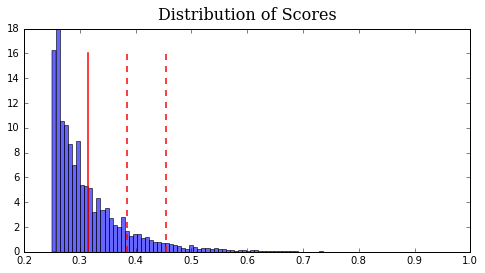

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline

font_title = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 16}  

plt.figure(1, figsize=(8,4))
plt.title("Distribution of Scores", fontdict = font_title)
plt.hist(scores, 100, normed = 1, alpha = 0.6, histtype='bar')
N = 17
plt.plot( [MEAN_SCORE for i in range (N)], range(N), linewidth = 1.5, color = 'r')
plt.plot( [MEAN_SCORE + STD_SCORE for i in range (N)], range(N), 'r--', linewidth = 1.5)
plt.plot( [MEAN_SCORE + 2*STD_SCORE for i in range (N)], range(N), 'r--', linewidth = 1.5)
plt.show() 

# Score > $\mu$ + $2\sigma$ 

In [50]:
bestCandidatesRDD = candidateScoresRDD.filter(lambda x: x[1] > MEAN_SCORE + 2*STD_SCORE)
bestCandidatesRDD.count()

366745

# Create clusters for each song

In [124]:
flatCouplesRDD = bestCandidatesRDD.flatMap(lambda x: [(x[0][0], x[0]), (x[0][1], x[0])])

#Group by key (song). Each song has now one cluster
def merge_couples(x, y):
    return list(set(x) | set(y))

songClusterRDD = flatCouplesRDD.reduceByKey(merge_couples)
songClusterRDD.count()


[(702464,
  [702464,
   262149,
   262151,
   262152,
   262153,
   262157,
   262159,
   262161,
   262162,
   262163,
   262166,
   262167,
   262170,
   262171,
   262173,
   262175,
   262179,
   262180,
   262182,
   4453554,
   262190,
   4453555,
   855220,
   855102,
   855104,
   855106,
   855107,
   553654,
   853064,
   553561,
   4453562,
   4453563,
   553660,
   4453565,
   553662,
   855163,
   855165,
   855167,
   855169,
   853127,
   853129,
   4453543,
   4453544,
   4453545,
   4453546,
   4453547,
   4453548,
   4453549,
   4453550,
   4453551,
   4453552,
   4453553,
   553650,
   553651,
   4453556,
   4453557,
   4453558,
   4453559,
   4453560,
   4453561,
   553658,
   553659,
   4453564,
   553661,
   4453566,
   553665,
   553667,
   4453750,
   553671,
   553672,
   553673,
   854221,
   553678,
   854230,
   854233,
   854747,
   854748,
   854750,
   854760,
   854763,
   854765,
   854913,
   855341,
   4453654,
   4453655,
   4453656,
   4453657,
   4

In [138]:
unionJoinRDD = tracksIdsRDD.leftOuterJoin(songClusterRDD)
unionRDD = unionJoinRDD.map(lambda x: (x[0], x[1][0]) if x[1][1] == None else (x[0], sorted(x[1][1])))
unionRDD.take(3)

[(1212416, [u'1212416']), (4849664, [u'4849664']), (1745808, [u'1745808'])]

In [141]:
clusterSongsRDD = unionRDD.map(lambda x: (' '.join([str(i) for i in x[1]]), x[0])).groupByKey()
clusterSongsRDD = clusterSongsRDD.zipWithIndex().map(lambda x: (x[1], list(x[0][1])) )
clusterSongsRDD.take(3)


[(0, [2431409]), (1, [2085172]), (2, [1575232])]

In [142]:
clusterSongsRDD.count()

4518663

In [143]:
tracksIdsRDD.count()

4519105

In [145]:
clusterDim = songClusterRDD.map(lambda x: len(x[1])).collect()


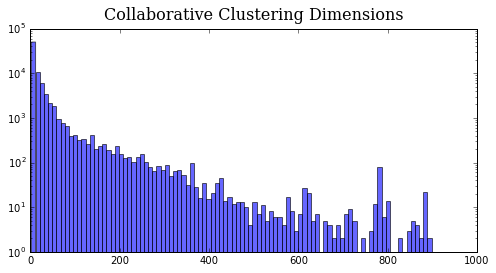

In [148]:
font_title = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 16}  

plt.figure(1, figsize=(8,4))
plt.title("Collaborative Clustering Dimensions", fontdict = font_title)
plt.hist(clusterDim, 100, normed = 0, alpha = 0.6, histtype='bar', log=True)
plt.show() 

In [150]:
clustersRDD = songClusterRDD.map(lambda x: ' '.join([str(i) for i in sorted(x[1])]))
previous_dim = clustersRDD.count()

clusterUniqueRDD = clustersRDD.distinct()
unique_n = clusterUniqueRDD.count()


In [153]:
clusterUniqueRDD = clusterUniqueRDD.map(lambda x: x.split(' '))
clusterUniqueRDD.take(1)

[['587279',
  '587302',
  '587321',
  '675420',
  '684702',
  '686911',
  '687127',
  '687356',
  '761349',
  '761364',
  '761368',
  '761372',
  '761381',
  '761382',
  '761389',
  '761390',
  '761397',
  '761400',
  '761414',
  '761415',
  '761430',
  '761431',
  '761435',
  '761440',
  '761441',
  '868216',
  '908812',
  '1036069',
  '1074411',
  '1074441',
  '1074457',
  '1074601',
  '1104080',
  '1104175',
  '1111169',
  '1111182',
  '1111205',
  '1111429',
  '1111586',
  '1111612',
  '1111701',
  '1111787',
  '1111844',
  '1111874',
  '1111932',
  '1112050',
  '1112191',
  '1229845',
  '1230315',
  '1230417',
  '1230985',
  '1231390',
  '1350443',
  '1435162',
  '1435176',
  '1435177',
  '1435202',
  '1435215',
  '1435259',
  '1435273',
  '1435274',
  '1435299',
  '1435317',
  '1435321',
  '1553915',
  '1558696',
  '1558720',
  '1558869',
  '1559005',
  '1559041',
  '1559116',
  '1675452',
  '1688235',
  '1689025',
  '1747940',
  '1818941',
  '1969707',
  '1969746',
  '1969768',
